In [13]:
!pip install python_speech_features speechrecognition
!pip install pydub librosa soundfile
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


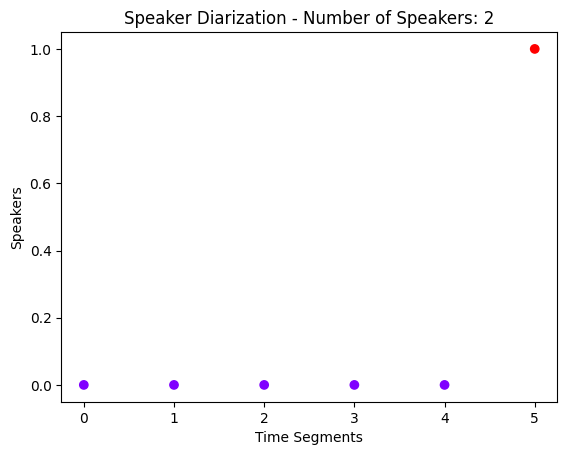

In [1]:
from pydub import AudioSegment
import numpy as np
import scipy.io.wavfile as wav
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import librosa
import librosa.display
import python_speech_features as psf
import speech_recognition as sr
import soundfile as sf  # Import soundfile to write audio

# Convert GSM format to PCM .wav using Pydub
audio = AudioSegment.from_file('/content/hard.wav', format="wav")
audio.export('/content/converted_audio.wav', format="wav")

# Load the converted .wav file using Librosa for noise reduction
audio_data, rate = librosa.load('/content/converted_audio.wav', sr=None)

# Function to apply noise reduction using librosa
def reduce_noise(audio_data, rate):
    # Apply noise reduction (you can tune the parameters if needed)
    audio_data = librosa.effects.preemphasis(audio_data)
    return audio_data

# Apply noise reduction
audio_data = reduce_noise(audio_data, rate)

# Export the cleaned audio to file for transcription using soundfile
sf.write('/content/cleaned_audio.wav', audio_data, rate)

# Function to extract MFCC features
# Function to extract MFCC features
def extract_mfcc(audio_data, rate, n_mfcc=13):
    mfcc_features = psf.mfcc(audio_data, rate, numcep=n_mfcc, nfft=1024)
    return np.mean(mfcc_features, axis=0)


# Function to segment and cluster speakers
def segment_and_cluster(audio_data, rate, n_segments=5, n_clusters=2):
    segment_size = len(audio_data) // n_segments
    mfcc_features = []

    for i in range(0, len(audio_data), segment_size):
        segment = audio_data[i:i + segment_size]
        mfcc = extract_mfcc(segment, rate)
        mfcc_features.append(mfcc)

    mfcc_features = np.array(mfcc_features)

    # Perform K-means clustering to differentiate speakers
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(mfcc_features)
    return kmeans.labels_, mfcc_features

# Perform segmentation and clustering
labels, features = segment_and_cluster(audio_data, rate)

# Count the number of unique speakers
num_speakers = len(np.unique(labels))

# Visualize speaker intervals
def visualize_speaker_intervals(labels):
    time_intervals = np.arange(len(labels))
    plt.scatter(time_intervals, labels, c=labels, cmap='rainbow')
    plt.title(f"Speaker Diarization - Number of Speakers: {num_speakers}")
    plt.xlabel("Time Segments")
    plt.ylabel("Speakers")
    plt.show()

# Visualize speaker intervals
visualize_speaker_intervals(labels)



###Google Speech Recognition

In [17]:
# Use Google Speech Recognition for transcription of each segment
recognizer = sr.Recognizer()

def speech_to_text(audio_file, start, end):
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source, duration=(end - start), offset=start)
        text = recognizer.recognize_google(audio_data)
        return text

# Transcribe each segment after noise reduction
segment_size = len(audio_data) // len(labels)
transcriptions = []
for i, label in enumerate(labels):
    start = i * segment_size
    end = (i + 1) * segment_size
    try:
        text = speech_to_text('/content/cleaned_audio.wav', start / rate, end / rate)
        transcriptions.append(f"Speaker {label}: {text}")
    except Exception as e:
        transcriptions.append(f"Speaker {label}: [Unrecognized speech]")

# Output number of speakers and transcriptions
print(f"Number of Speakers: {num_speakers}")
for transcription in transcriptions:
    print(transcription)


Number of Speakers: 2
Speaker 0: you have been hanging out in the wrong clubs Mr
Speaker 0: [Unrecognized speech]
Speaker 0: [Unrecognized speech]
Speaker 0: catalyst
Speaker 0: [Unrecognized speech]
Speaker 1: I just wanted you to know how hard it was


###Open AI Whisperer

In [20]:
!pip uninstall whisper -y  # Uninstall any other 'whisper' package
!pip install openai-whisper  # Install OpenAI Whisper
!pip install torch  # PyTorch is required for Whisper


Found existing installation: whisper 1.1.10
Uninstalling whisper-1.1.10:
  Successfully uninstalled whisper-1.1.10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=e3fe31b57101082f19739fb05df2e6693144f5d1e4693a1117542ea13156e910
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [2]:
import whisper

# Load Whisper model
model = whisper.load_model("base")

# Transcribe the audio using Whisper
def whisper_transcribe(audio_file):
    result = model.transcribe(audio_file)
    return result['text']

# Example of transcribing an audio segment
transcription = whisper_transcribe("/content/cleaned_audio.wav")
print(transcription)


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 156MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

 You have been hanging out in the wrong clubs, Mr. Wayne. I called Mr. Fox when your condition worsened after the first day. I analyzed your blood, isolating the receptor compounds in the protein-based catalyst. I'm in a misunderstanding, either. Not at all. I just wanted you to know how hard it was.


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


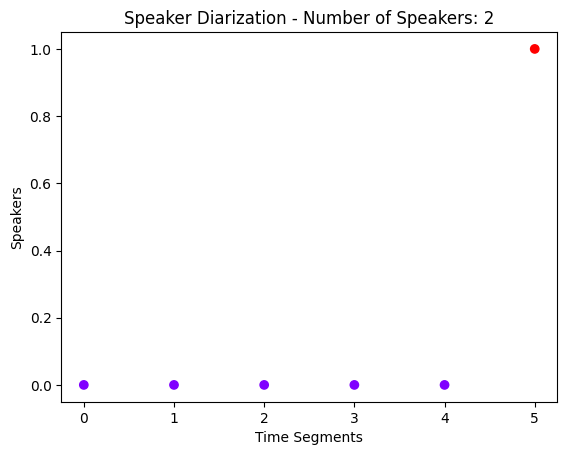

Speaker 1:  You have been hanging out in the wrong clubs, Mr. Wayne.
Speaker 1:  I call Mr. Fox when your condition worsened after the first.
Speaker 1:  I analyzed your blood isolating the receptor.
Speaker 1:  to compounds in the protein-based catalyst.
Speaker 1:  I'm gonna understand any of that. Not for...
Speaker 2:  I just wanted you to know how hard it was.


In [5]:
import warnings
warnings.filterwarnings("ignore", message="FP16 is not supported on CPU; using FP32 instead")

from pydub import AudioSegment
import numpy as np
import scipy.io.wavfile as wav
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import librosa
import librosa.display
import python_speech_features as psf
import soundfile as sf  # For saving audio
import whisper

# Convert GSM format to PCM .wav using Pydub
audio = AudioSegment.from_file('/content/hard.wav', format="wav")
audio.export('/content/converted_audio.wav', format="wav")

# Load the converted .wav file using Librosa for noise reduction
audio_data, rate = librosa.load('/content/converted_audio.wav', sr=None)

# Function to apply noise reduction using librosa
def reduce_noise(audio_data, rate):
    # Apply noise reduction (pre-emphasis)
    audio_data = librosa.effects.preemphasis(audio_data)
    return audio_data

# Apply noise reduction
audio_data = reduce_noise(audio_data, rate)

# Export the cleaned audio to file for transcription using soundfile
sf.write('/content/cleaned_audio.wav', audio_data, rate)

# Load Whisper model
model = whisper.load_model("base")

# Function to extract MFCC features
def extract_mfcc(audio_data, rate, n_mfcc=13):
    mfcc_features = psf.mfcc(audio_data, rate, numcep=n_mfcc, nfft=1024)
    return np.mean(mfcc_features, axis=0)

# Function to segment and cluster speakers
def segment_and_cluster(audio_data, rate, n_segments=5, n_clusters=2):
    segment_size = len(audio_data) // n_segments
    mfcc_features = []

    for i in range(0, len(audio_data), segment_size):
        segment = audio_data[i:i + segment_size]
        mfcc = extract_mfcc(segment, rate)
        mfcc_features.append(mfcc)

    mfcc_features = np.array(mfcc_features)

    # Perform K-means clustering to differentiate speakers
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(mfcc_features)
    return kmeans.labels_

# Function to transcribe using Whisper on specific segments
def whisper_transcribe_segment(audio_segment):
    # Save the specific segment for Whisper to transcribe
    sf.write('/content/temp_segment.wav', audio_segment, rate)
    result = model.transcribe('/content/temp_segment.wav')
    return result['text']

# Perform speaker diarization
labels = segment_and_cluster(audio_data, rate)

# Count the number of unique speakers
num_speakers = len(np.unique(labels))

# Visualize speaker intervals
def visualize_speaker_intervals(labels):
    time_intervals = np.arange(len(labels))
    plt.scatter(time_intervals, labels, c=labels, cmap='rainbow')
    plt.title(f"Speaker Diarization - Number of Speakers: {num_speakers}")
    plt.xlabel("Time Segments")
    plt.ylabel("Speakers")
    plt.show()

# Visualize speaker intervals
visualize_speaker_intervals(labels)

# Transcribe and assign speakers using actual audio segments
segment_size = len(audio_data) // len(labels)
transcriptions = []
for i, label in enumerate(labels):
    start = i * segment_size / rate
    end = (i + 1) * segment_size / rate

    # Extract the corresponding audio segment
    audio_segment = audio_data[int(start * rate):int(end * rate)]

    try:
        # Transcribe the actual audio segment
        transcription = whisper_transcribe_segment(audio_segment)
        transcriptions.append(f"Speaker {label + 1}: {transcription}")
    except Exception as e:
        transcriptions.append(f"Speaker {label + 1}: [Unrecognized speech]")

# Output labeled transcription
for transcription in transcriptions:
    print(transcription)
